2×2 Matrix{Int64}:
  9  9
 10  9

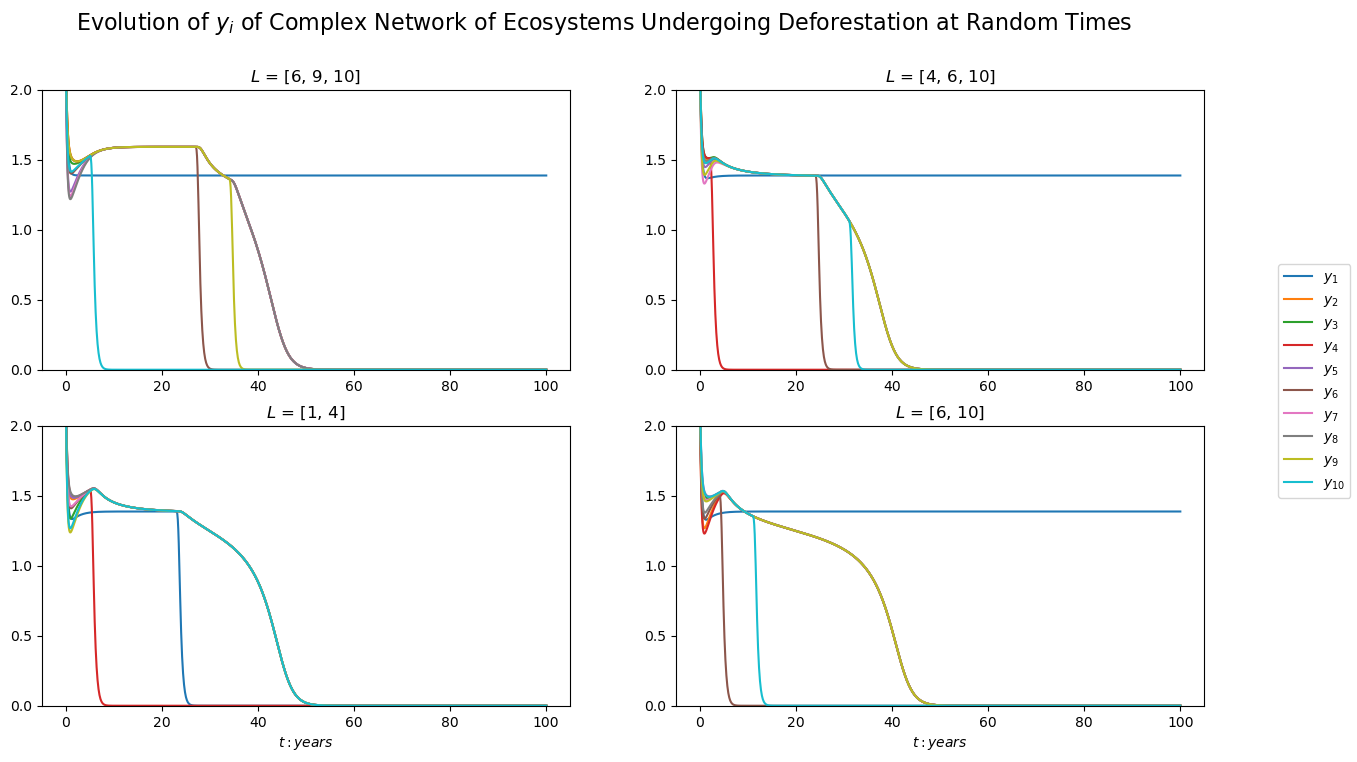

In [1]:
# Reproduce figure 9 from Cantin2020: perturb network through deforestation
# TODO: could make this a broken axis to highlight difference in 
# This figure is apparently wrong...
using Distributions
using Random
using PyPlot
using DrWatson
using Suppressor
using LaTeXStrings
using DynamicalSystems
using CSSim

# Forests `L` to deforest (from figure 9)
ecosystems_to_deforest_mat = [
    [6, 9, 10],
    [4, 6, 10],
    [1, 4],
    [6, 10],
]

# Generate parameters
n = 10
T = 100
D = 900
#tstar = 15
close_to_zero_atol = 1e-5
params_container = [
    Dict{Symbol,Any}(
        :ρ  => 4.2, 
        :f  => 1.0,
        :α₀ => -1.0, 
        :w₀ =>  1.0,
        :a₁ => 1.0, 
        :h  => 2.0, 
        :a₂ => 0.0, 
        :d  => repeat([D / (n-1)], n-1), 
        :l  => 600.0, 
        :P₀ => 1.05, 
        :β₁ => 0.0, 
        :β₂ => 0.15,
        :n  => n,
        :ecosystems_to_deforest => ecosystems_times_to_deforest(
            40, 

            # list of ecosystems to deforest
            # NOTE: pass an empty list `[]` if you want random ecosystems 
            ecosystems_to_deforest,

            # list of times at which ecosystems are deforested
            # NOTE: pass an empty list `[]` if you want random times 
            #repeat([tstar], length(ecosystems_to_deforest)), 
            [],
            n, 
            ix # different random seed
        ),
    )
    for (ix, ecosystems_to_deforest) in enumerate(ecosystems_to_deforest_mat)];

# Evolution of yᵢ given perturbations
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
    
y_density = 2.25 # starting y 
x_ix = 1
y_ix = 2
n_states = 2
dead_systems = Matrix{Int}(undef, nrows, ncols)
@suppress_err begin
    for i in 1:nrows
        for j in 1:ncols
            flat_ix = (i-1)*ncols + j
            params = params_container[flat_ix]

            # Generate initial conditions 
            #u0 = 4*rand(MersenneTwister((i*nrows)+j), params[:n], n_states) 
            u0 = y_density*ones(params[:n], n_states)
            u0[:, x_ix] .= 2*rand(MersenneTwister((i*nrows)+j), params[:n])


            # Compute trajectories
            n_forest_ds = n_forest_system(u0, params)
            S, t = trajectory(n_forest_ds, T)
            S_tensor = reshape(Matrix(S), :, params[:n], n_states)

            # iterate through ecosystems and plot trajectories
            dead_systems_in_system_i = 0
            for k in 1:params[:n]
                y_k = S_tensor[:, k, y_ix]
                y_k_last = y_k[end]

                # track dead systems
                if isapprox(y_k_last, 0.0; atol=close_to_zero_atol)
                    dead_systems_in_system_i += 1
                end 

                axs[i, j].plot(t, y_k, label=LaTeXString("\$y_{$(k)}\$"))
            end 

            # update dead systems matrix
            dead_systems[i, j] = dead_systems_in_system_i

            i == nrows ? axs[i, j].set_xlabel(L"$t: years$") : nothing
            axs[i, j].set_title(
                LaTeXString(
                    "\$L\$ = $(getproperty.(params[:ecosystems_to_deforest], :i))"))

            # scaling to range 
            axs[i, j].set_ylim((0, 2))
            start_y, end_y = axs[i, j].get_ylim()
            axs[i, j].set_yticks(start_y:0.50:end_y)
        end 
    end 
end 

display(dead_systems)

# Figure labeling
fig.suptitle(
    LaTeXString(
        "Evolution of \$y_i\$ of Complex Network of Ecosystems Undergoing Deforestation at Random Times"), 
    fontsize=16)

handles, labels = axs[1, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right")
fig